In [32]:
import random
import pandas as pd
import numpy as np
import os
import cv2
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torchvision.models as models

from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore') 

In [3]:
df_train = pd.read_csv('open/train.csv')
df_test = pd.read_csv('open/test.csv')
df_train.head()

,ID,img_path,mask_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,...,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category
0,BC_01_0001,./train_imgs/BC_01_0001.png,-,63,2015-10-23,1,2,1,19.0,2.0,...,8.0,1.0,6.0,12.0,0.0,1.0,NaN,NaN,NaN,0
1,BC_01_0002,./train_imgs/BC_01_0002.png,-,51,2015-10-28,1,1,1,22.0,3.0,...,NaN,0.0,NaN,70.0,0.0,0.0,NaN,NaN,NaN,1
2,BC_01_0003,./train_imgs/BC_01_0003.png,-,37,2015-10-29,1,2,1,NaN,2.0,...,7.0,1.0,4.0,7.0,0.0,1.0,NaN,NaN,0.0,0
3,BC_01_0004,./train_imgs/BC_01_0004.png,-,54,2016-03-08,1,2,1,0.0,3.0,...,NaN,0.0,NaN,1.0,1.0,3.0,NaN,NaN,NaN,0
4,BC_01_0005,./train_imgs/BC_01_0005.png,-,57,2015-10-30,1,2,1,8.0,2.0,...,8.0,0.0,NaN,8.0,1.0,2.0,1.0,5.44,NaN,0


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 1000 non-null   object 
 1   img_path           1000 non-null   object 
 2   mask_path          1000 non-null   object 
 3   나이                 1000 non-null   int64  
 4   수술연월일              1000 non-null   object 
 5   진단명                1000 non-null   int64  
 6   암의 위치              1000 non-null   int64  
 7   암의 개수              1000 non-null   int64  
 8   암의 장경              931 non-null    float64
 9   NG                 949 non-null    float64
 10  HG                 914 non-null    float64
 11  HG_score_1         908 non-null    float64
 12  HG_score_2         908 non-null    float64
 13  HG_score_3         911 non-null    float64
 14  DCIS_or_LCIS_여부    1000 non-null   int64  
 15  DCIS_or_LCIS_type  126 non-null    float64
 16  T_category         996 no

In [6]:
df_train.mask_path.value_counts()

-                               942
./train_masks/BC_01_0893.png      1
./train_masks/BC_01_0668.png      1
./train_masks/BC_01_0673.png      1
./train_masks/BC_01_0674.png      1
./train_masks/BC_01_0681.png      1
./train_masks/BC_01_0693.png      1
./train_masks/BC_01_0694.png      1
./train_masks/BC_01_0876.png      1
./train_masks/BC_01_0877.png      1
./train_masks/BC_01_0881.png      1
./train_masks/BC_01_0883.png      1
./train_masks/BC_01_0885.png      1
./train_masks/BC_01_0886.png      1
./train_masks/BC_01_0902.png      1
./train_masks/BC_01_0660.png      1
./train_masks/BC_01_0905.png      1
./train_masks/BC_01_0906.png      1
./train_masks/BC_01_0907.png      1
./train_masks/BC_01_0912.png      1
./train_masks/BC_01_0922.png      1
./train_masks/BC_01_0925.png      1
./train_masks/BC_01_0928.png      1
./train_masks/BC_01_0936.png      1
./train_masks/BC_01_0938.png      1
./train_masks/BC_01_0947.png      1
./train_masks/BC_01_0974.png      1
./train_masks/BC_01_0980.png

In [22]:
df_train['암의 장경'] = df_train['암의 장경'].fillna(df_train['암의 장경'].mean())
df_test['암의 장경'] = df_test['암의 장경'].fillna(df_test['암의 장경'].mean())
df_train = df_train.fillna(0)
df_test = df_test.fillna(0)

In [23]:
df_train.drop(columns=['ID', 'img_path', 'mask_path', '수술연월일'], inplace=True)
df_test.drop(columns=['ID', 'img_path', '수술연월일'], inplace=True)

In [25]:
X_train = df_train.iloc[:, :23]
y_train = df_train.iloc[:, 23]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [28]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
pred = model.predict()

RandomForestClassifier()

Index(['나이', '진단명', '암의 위치', '암의 개수', '암의 장경', 'NG', 'HG', 'HG_score_1',
       'HG_score_2', 'HG_score_3', 'DCIS_or_LCIS_여부', 'DCIS_or_LCIS_type',
       'T_category', 'ER', 'ER_Allred_score', 'PR', 'PR_Allred_score',
       'KI-67_LI_percent', 'HER2', 'HER2_IHC', 'HER2_SISH', 'HER2_SISH_ratio',
       'BRCA_mutation'],
      dtype='object')


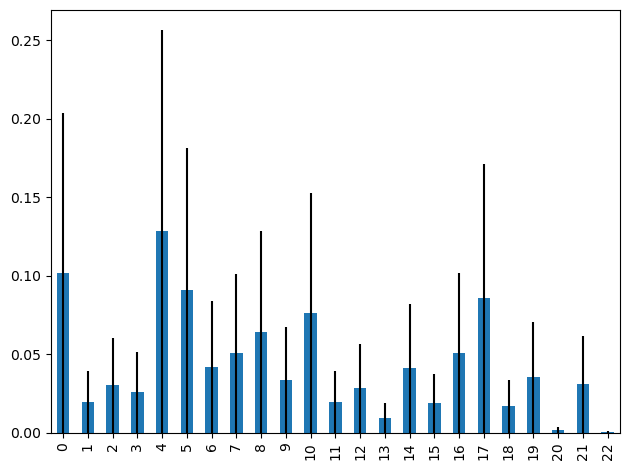

In [40]:
importances = model.feature_importances_
forest_importances = pd.Series(importances)
# std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=forest_importances, ax=ax)
fig.tight_layout()

print(X_train.columns)

image

In [10]:
# get image path
img_path_list.extend(df_train['img_path'])
label_list.extend(df_train['N_category'])

['./train_imgs/BC_01_0001.png',
 './train_imgs/BC_01_0002.png',
 './train_imgs/BC_01_0003.png',
 './train_imgs/BC_01_0004.png',
 './train_imgs/BC_01_0005.png',
 './train_imgs/BC_01_0006.png',
 './train_imgs/BC_01_0007.png',
 './train_imgs/BC_01_0008.png',
 './train_imgs/BC_01_0009.png',
 './train_imgs/BC_01_0010.png',
 './train_imgs/BC_01_0012.png',
 './train_imgs/BC_01_0013.png',
 './train_imgs/BC_01_0014.png',
 './train_imgs/BC_01_0015.png',
 './train_imgs/BC_01_0062.png',
 './train_imgs/BC_01_0178.png',
 './train_imgs/BC_01_0204.png',
 './train_imgs/BC_01_0213.png',
 './train_imgs/BC_01_0214.png',
 './train_imgs/BC_01_0215.png',
 './train_imgs/BC_01_0216.png',
 './train_imgs/BC_01_0217.png',
 './train_imgs/BC_01_0218.png',
 './train_imgs/BC_01_0223.png',
 './train_imgs/BC_01_0224.png',
 './train_imgs/BC_01_0226.png',
 './train_imgs/BC_01_0227.png',
 './train_imgs/BC_01_0229.png',
 './train_imgs/BC_01_0230.png',
 './train_imgs/BC_01_0232.png',
 './train_imgs/BC_01_0234.png',
 './trai

In [14]:
image = cv2.imread('open'+img_path_list[0][1:])
print(image)

[[[244 244 244]
  [244 244 244]
  [244 244 244]
  ...
  [244 244 244]
  [244 244 244]
  [244 244 244]]

 [[244 244 244]
  [244 244 244]
  [244 244 244]
  ...
  [244 244 244]
  [244 244 244]
  [244 244 244]]

 [[244 244 244]
  [244 244 244]
  [244 244 244]
  ...
  [244 244 244]
  [244 244 244]
  [244 244 244]]

 ...

 [[242 242 242]
  [242 242 242]
  [243 243 243]
  ...
  [241 241 240]
  [241 241 240]
  [241 240 240]]

 [[242 242 242]
  [242 242 242]
  [243 243 243]
  ...
  [241 241 240]
  [241 241 240]
  [241 240 240]]

 [[242 239 233]
  [242 243 240]
  [242 244 240]
  ...
  [240 240 240]
  [240 240 240]
  [240 240 240]]]


In [19]:
image.shape

(3003, 6141, 3)